## Introduccion

En Los Ángeles existe un sistema compartido de bicicletas que brinda datos anónimos acerca
del uso del servicio. La tabla que se proporciona contiene el histórico de viajes que se han
realizado desde 2016.

En este analísis buscamos resolver preguntas acerca del uso del servicio.
- Sobre la saturación del servicio, analizaremos el uso por día, horas y las estaciones con más demanda.
- Estudiamos la tendencia en el uso del servicio y en los planes ofrecidos.

## Librerias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## EDA

Comenzamos leyendo el archivo "train_set.csv", primero daremos un vistazo rapido al dataset y haremos una limpieza para su posterior analisis

In [2]:
df = pd.read_csv('data/train_set.csv', low_memory=False)
print(f'Total registers: {len(df)}')
df.sample(5)

Total registers: 700000


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
654637,178649321,11,12/19/2021 19:22,12/19/2021 19:33,34.046131,-118.257591,34.047440,-118.247940,12197,1.0,One Way,Walk-up,3064,4491
683182,108795754,7,2018-11-05 08:47:00,2018-11-05 08:54:00,34.056610,-118.237213,34.051941,-118.243530,06487,30.0,One Way,Monthly Pass,3014,3030
222735,92617542,5,2018-06-17 18:33:00,2018-06-17 18:38:00,34.052898,-118.241562,34.046822,-118.248352,05956,0.0,One Way,Walk-up,3016,3038
544840,94966550,341,2018-07-01 11:56:00,2018-07-01 17:37:00,34.023392,-118.479637,34.023392,-118.479637,06693,1.0,Round Trip,One Day Pass,4216,4216
688624,48188796,55,9/25/2017 18:34,9/25/2017 19:29,34.135250,-118.132370,34.135250,-118.132370,12024,0.0,Round Trip,Walk-up,4158,4158


Comencemos usando las herramientas que nos proporciona pandas para analizar de forma general los datos que vamos a utilizar

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 74.8+ MB


In [4]:
df.describe()

,trip_id,duration,start_lat,start_lon,end_lat,end_lon,plan_duration,start_station,end_station
count,7.000000e+05,700000.000000,694437.000000,694437.000000,681426.000000,681426.000000,699792.000000,700000.000000,700000.000000
mean,1.069468e+08,37.084979,34.044952,-118.253849,34.044175,-118.259183,44.928697,3499.720464,3489.726771
std,4.497342e+07,125.302510,0.325255,2.332640,0.299721,2.129781,92.816296,615.918795,613.040769
min,8.369648e+06,1.000000,33.710979,-118.495422,33.710979,-118.495422,0.000000,3000.000000,3000.000000
25%,7.538051e+07,7.000000,34.037460,-118.280952,34.037048,-118.280952,1.000000,3031.000000,3030.000000
50%,1.179410e+08,13.000000,34.046612,-118.256980,34.046520,-118.256981,30.000000,3064.000000,3064.000000
75%,1.404178e+08,26.000000,34.051941,-118.247162,34.050911,-118.246422,30.000000,4214.000000,4214.000000
max,1.794831e+08,1440.000000,55.705528,118.238258,55.705528,37.606541,999.000000,4594.000000,4594.000000


De primera mano se puede observar que:
- Las columnas **start_time** y **end_time** son de tipo *str*, hay que modificar a tipo *timestamp* y con el formato indicado

- Primero ajustaremos la columna *start_time* y *end_time* al formato deseado
- Al ver algunos ejemplos en la tabla vemos dos formatos de fecha mezclados: *"year-month-day"* y *"month/day/year"* la segunda forma hay que ajustarla para poder cumplir con el formato de fecha indicado y posteriormente convertir a timpo *datetime* usando la funcion to_datetime de pandas corregimos esta situacion

In [5]:
# Transformaremos las columnas a tipo datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

Viendo la descripcion numerica de las columnas tambien podemos observar algunas irregularidades, 
- El total de registros son 700 000, pero ciertas columnas tienen un conteo menor a esta cantidad lo que implicar que hay campos vacios. Sin embargo nos interesa conocer la saturacion en las estaciones y esta columna contiene informacion completa, asi que por el momento conservaremos todos los datos.

Se puede observar el comportamiento de un dato atipico, en la fila *max* observamos un viaje con duracion de 1440 min recortaremos este dato para que no afecte nuestro analisis.

In [6]:
# Verificamos el numero de datos con una duracion de 1440
len(df[df['duration'] == 1440])

2931

Buscando sobre este dato encontramos casi 3000 registros que marcan un viaje con la misma duracion, podriamos investigarse el porque obtenemos esta informacion, si es algun fallo u otro motivo, pero lo ignoraremos para este caso de estudio.

In [7]:
# Crearemos una copia del dataset para continuar con la limpieza
# Recortamos los datos con duracion de 1440 y actualizamos el dataset

df_cln = df[df['duration'] != 1440]
print(len(df_cln))

697069


Tambien se encontraron irregularidades en las columnas que contienen datos de geolocalizacion 

- *start_lat* 
- *start_lon*
- *end_lat*
- *end_lon*

cotienen valores atipicos que no corresponden a la region estudiada, por lo tanto seran retirados del dataset

In [8]:
# Las coordenadas correspondientes a Los Angeles CA, estan entre lat=35.0 y lon=-118.0
# Actualizamos el dataset recortando los datos con valores muy alejados a la coordenadas de Los Angeles
df_cln = df_cln[df_cln['start_lat'] < 40.0]
df_cln = df_cln[df_cln['start_lon'] < -100.0]
df_cln = df_cln[df_cln['end_lat'] < 40.0]
df_cln = df_cln[df_cln['end_lon'] < -100.0]

### Analizando la demanda del servicio a traves del tiempo

Veamos como a sido en general el crecimiento en el uso del servicio

In [9]:
# Crearemos una nueva columna basada en star_time para manejar las fechas

df_cln['date'] = df_cln['start_time'].apply(lambda x: x.date())

In [10]:
time_analysis = df_cln.copy() # Nuevo dataframe para el analisis temporal

time_analysis.set_index('date', inplace=True) # Definimos la columna date como indice para analísis de series de tiempo
time_analysis.index = pd.to_datetime(time_analysis.index)
time_analysis.sort_index(inplace=True) # Ordenamos las fechas de la más antigua a la más reciente

Crearemos nuevas columnas para describir a mayor detalle el uso de las biciletas, estas seran *year*, *month*, *weekday*, *hour*

In [11]:
time_analysis['year'] = time_analysis['start_time'].apply(lambda x: x.year)
time_analysis['month'] = time_analysis['start_time'].apply(lambda x: x.month)
time_analysis['day'] = time_analysis['start_time'].apply(lambda x: x.weekday())
time_analysis['hour'] = time_analysis['start_time'].apply(lambda x: x.hour)

Grafiquemos como ha sido el uso de el servicio de forma mensual

In [12]:
# Agrupamos por mes y contamos el número de viajes realizados en ese lapso 
month_analysis = time_analysis.resample('M')[['trip_id']].count() 

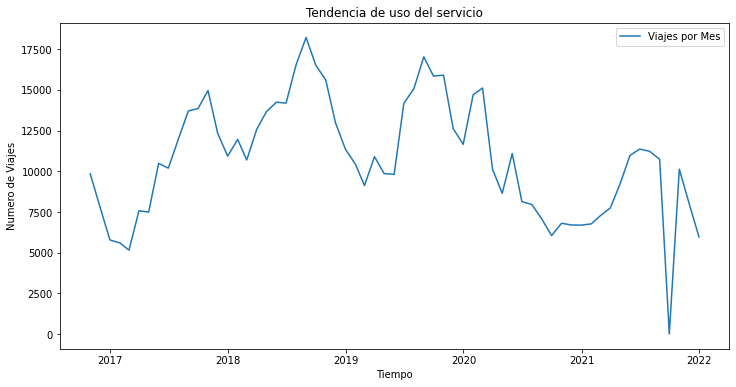

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(month_analysis, label='Viajes por Mes')
plt.title('Tendencia de uso del servicio')
plt.xlabel('Tiempo')
plt.ylabel('Numero de Viajes')
plt.legend()
plt.savefig('images/time_series.png', format='png')

Claramente vemos una caída en el uso del servicio a partir de Marzo de 2020, fecha relacionada con el incremento de las medidas sanitarias a causa del Covid-19. 

Encontramos que en septiembre de 2021 no tenemos datos, usaremos los datos de años anteriores para del mismo mes para llenar esta fecha vacía.

In [14]:
# Calculamos la media de viajes en el mes de septiembre y lo asignamos al mes de septiembre de 2021
month_analysis.loc['2021-9-30'] = int(month_analysis[month_analysis.index.month==9]['trip_id'].mean())

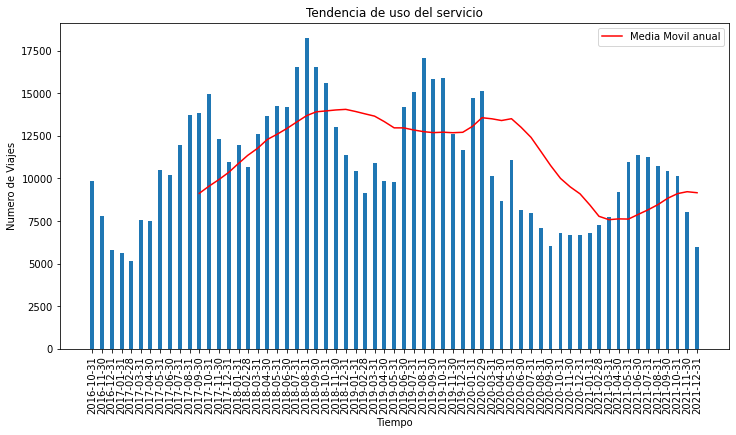

In [15]:
plt.figure(figsize=(12, 6))
plt.bar(month_analysis.index, month_analysis['trip_id'], width=12)
# Medimos y graficamos el uso de forma anual
plt.plot(month_analysis.rolling(12).mean(), label='Media Movil anual', color='r')
plt.title('Tendencia de uso del servicio')
plt.xlabel('Tiempo')
plt.xticks(month_analysis.index, rotation=90)
plt.ylabel('Numero de Viajes')
plt.legend()

plt.savefig('images/time_series_tencency.png')

En esta grafica podemos apreciar la tencencia en el uso del servicio, en 2 años tuvo un crecimiento acelerado, en 2019 y principios de 2020 se estabilizaba el su uso, pero este cayo debido a la pandemia global.

In [16]:
# Agruparemos el numero de viajes por año y mes

year_month = time_analysis.groupby(['month', 'year'])[['trip_id']].count()

En la tabla podemos notar que el uso del servicio es mayor en el tercer trimestre del año, correspodiente a la estacion de verano

### Analizando el uso por dias y horas

Ahora analizaremos como se comportan los usuarios a lo largo de la semana y las horas del dia

In [17]:
# Contaremos el numero de viajes por dia
date_hour = time_analysis.groupby(['date', 'day','hour'])[['trip_id']].count()

In [18]:
# Mediremos el numero medio de viajes por dia y hora
trips_by_day_hour = pd.pivot_table(date_hour, values=['trip_id'], index='day', columns='hour', aggfunc={'trip_id': 'mean'})

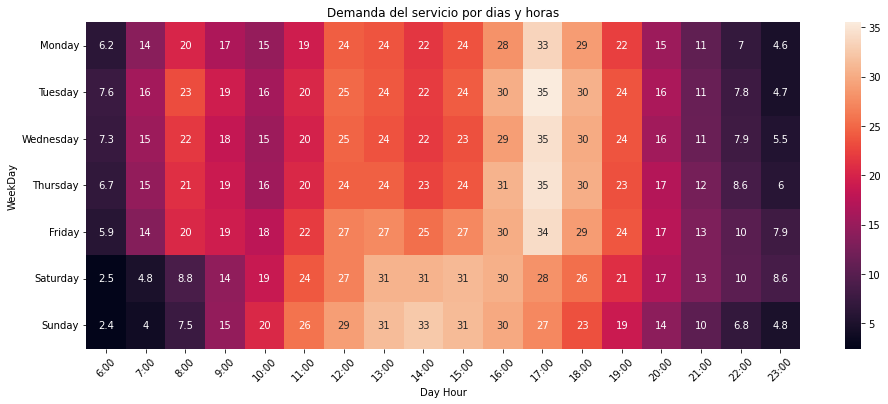

In [19]:
hour_labels = ['{}:00'.format(hour) for hour in range(6, 24)] # Lista de horas desde las 6 a las 24

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(trips_by_day_hour.iloc[:,6:], annot=True) # Comenzaremos graficando a partir de las 6 hrs

ax.set_title('Demanda del servicio por dias y horas')
ax.set_xlabel('Day Hour')
ax.set_xticklabels(hour_labels, rotation=45)
ax.set_ylabel('WeekDay')
ax.set_yticklabels(['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=0)

plt.savefig('images/heatmap_demand.png')

Aqui podemos observar que la mayor demanda de viajes sucede en:

- Lunes a Viernes de 16:00 a 18:00 horas
- Sabado y Domingo de 12:00 a 16:00 horas

Sin embargo hay un uso considerable del servicio desde las 8:00 hasta las 19:00 horas

### Analizando trayectorias

Veamos de donde salen y a donde van nuestros usuarios

In [20]:
trayectory_analysis = time_analysis.copy() # Copiamos el dataset de analísis de tiempo 

Vamos a contar el numero de viajes, desde que estacion salen y a que estacion llegan, tambien estandarizaremos los valores de latitud y longitud

In [21]:
# Agrupamos por fecha y horas, y definimos la ubicación de cada estación usando la media de las coordenadas

# Agrupación de la estación de inicio, contamos el núimero de viajes iniciadoa ahí
start_station = trayectory_analysis.groupby(['date', 'start_station']).agg({'start_lat':'mean', 'start_lon': 'mean', 'trip_id': 'count'})
# Agrupación de la estación de fin, contamos el núimero de viajes iniciadoa ahí
end_station = trayectory_analysis.groupby(['date', 'end_station']).agg({'end_lat':'mean', 'end_lon': 'mean', 'trip_id': 'count'})

Ahora mediremos el número medio de vajes al día por estación

In [22]:
# Agrupamos por estación y calculamos el número de viajes usando la media
mean_trips_by_start_station = start_station.groupby('start_station').agg({'start_lat':'mean', 'start_lon': 'mean', 'trip_id': 'mean'})
mean_trips_by_end_station = end_station.groupby('end_station').agg({'end_lat':'mean', 'end_lon': 'mean', 'trip_id': 'mean'})

Entonces grafiquemos las estaciones con mayor demanda al día 

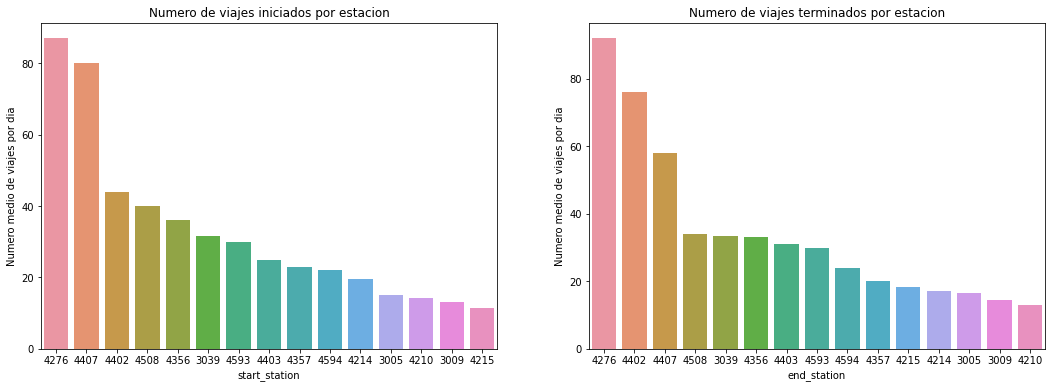

In [23]:
mean_trips_by_start_station.sort_values(by='trip_id', ascending=False, inplace=True)
mean_trips_by_end_station.sort_values(by='trip_id', ascending=False, inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(18,6))
sns.barplot(x=mean_trips_by_start_station.index[:15], 
            y='trip_id', 
            data=mean_trips_by_start_station[:15], 
            order=mean_trips_by_start_station.index[:15],
            ax=axs[0])
sns.barplot(x=mean_trips_by_end_station.index[:15], 
            y='trip_id', 
            data=mean_trips_by_end_station[:15], 
            order=mean_trips_by_end_station.index[:15],
            ax=axs[1])
axs[0].set_title('Numero de viajes iniciados por estacion')
axs[0].set_ylabel('Numero medio de viajes por dia')
axs[1].set_title('Numero de viajes terminados por estacion')
axs[1].set_ylabel('Numero medio de viajes por dia')

plt.savefig('images/station_demand.png')

Ahora veamos como se relaciona el tipo de viaje realizado *trip_route_category* con el número de viajes y las estaciones.

In [24]:
trayectory_analysis['trip_route_category'].unique()

array(['One Way', 'Round Trip'], dtype=object)

In [25]:
route_analysis = trayectory_analysis.groupby(['date', 'passholder_type', 'trip_route_category', 'start_station', 'end_station']
                                            ).agg({'start_lat':'mean', 'start_lon':'mean', 'end_lat':'mean', 'end_lon': 'mean', 'trip_id':'count'})
                                            # Estandarizar las coordenadas de cada estacion
route_analysis.reset_index(inplace=True)

Ahora grafiquemos cuales son las estaciones con mas concurrencia y que tipos de pase son mas comunes en cada una de ellas.

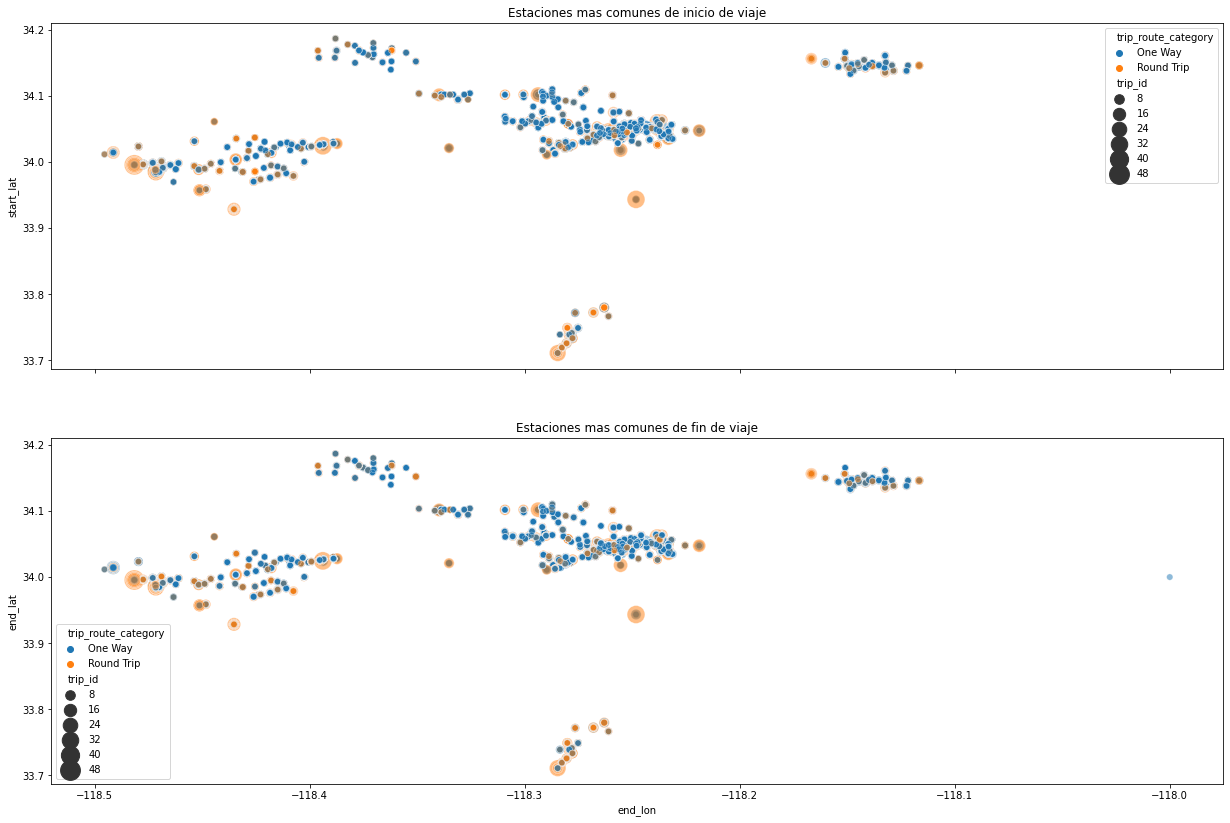

In [26]:
fig, axs = plt.subplots(2,1, figsize=(21, 14), sharex=True)
sns.scatterplot(x='start_lon', 
                y='start_lat', 
                hue='trip_route_category', 
                size='trip_id', 
                sizes=(40, 400),
                alpha=0.5,
                ax=axs[0],
                data=route_analysis)
axs[0].set_title('Estaciones mas comunes de inicio de viaje')

sns.scatterplot(x='end_lon', 
                y='end_lat', 
                hue='trip_route_category', 
                size='trip_id', 
                sizes=(40, 400),
                alpha=0.5,
                ax=axs[1],
                data=route_analysis)
axs[1].set_title('Estaciones mas comunes de fin de viaje')

plt.savefig('images/station_demand_coord.png')

Podemos observar que la mayor concentracion de viajes al dia son para viajes tipo "Round Trip", pero solo en ciertas zonas.

En cambio el tipo de viaje "One Way" es el que tiene mas usuarios diarios y con mayor distribucion geográfica

Veamos como es la transferencia de bicicletas entre estaciones

Para este estudio los viajes de interes son los de tipo "One Way", entonce filtraremos esta categoria

In [27]:
one_way = route_analysis[route_analysis['trip_route_category'] == 'One Way']

In [28]:
# Agrupamos el numero de viajes por estacion de salida y estacion de llegada por dia
one_way_analysis = one_way.groupby(['date', 'start_station', 'end_station'])[['trip_id']].sum()
one_way_analysis.reset_index(inplace=True)

In [29]:
# Agrupamos la mediana de numero de viajes entre estaciones
one_way_stations_grouped = one_way_analysis.groupby(['start_station', 'end_station'])[['trip_id']].median()
one_way_stations_grouped.sort_values('trip_id', ascending=False, inplace=True)

Vemos que en promedio la mayoria de las estaciones los viajes "One Way" no supera la cantidad de 1 viaje al dia, estudiemos las estaciones con más de 5 transacciones diarias

Filtremos este dato

24


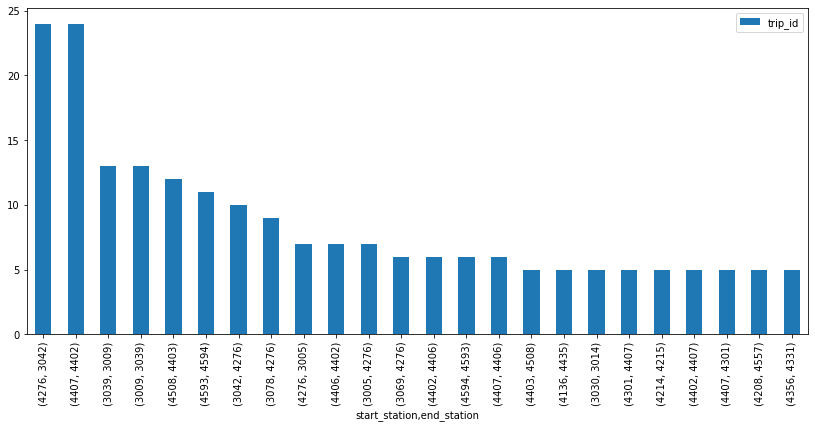

In [30]:
# Tomaremos el par de estaciones que cumplan con mas de 4 viajes diarios en promedio 
most_station_one_way_trips = one_way_stations_grouped[one_way_stations_grouped['trip_id'] >=5]
most_station_one_way_trips.plot(kind='bar', figsize=(14,6))
print(len(most_station_one_way_trips))

plt.savefig('images/transactions_btw_stations.png')

Vemos que tenemos 24 transacciones de viajes entre estaciones que superan mas de 4 viajes al día

Pero hay 7 transacciones donde se superan los 10 viajes promedios al día, y en los que el suministro de bicicletas debe considerarse mayor para evitar carencias en el suministro del servicio

### Analizando el tipo de pase

Ahora analizaremos que pasa con el tipo de pase, como han aumentado los usuarios con el tiempo y cuantos usuarios tenemos hasta el ultimo censo
- Cuantos tipos de pase tenemos?

In [31]:
passtype_analysis  = df_cln.copy()

In [32]:
# Listemos que tipos de pases existen

passtype_analysis['passholder_type'].unique()

array(['Walk-up', 'Monthly Pass', 'One Day Pass', 'Annual Pass',
       'Flex Pass', nan, 'Testing'], dtype=object)

Para este caso quitaremos los valores nulos ya que son nuestro punto de interes

In [33]:
passtype_analysis.dropna(subset='passholder_type', inplace=True)

Es complicado ser especificos sobre los usuarios y cuantos pases de cada tipo existen, ya que el dataset no tiene algun dato como usuario_id, sin embargo, podemos analizar como es el uso de cada pase y como ha evolucionado con el tiempo

Comenzaremos dando un vistazo a los tipos de pase y su frecuencia de uso de manera general

In [34]:
passtype_analysis['passholder_type'].value_counts()

Monthly Pass    387449
Walk-up         203103
One Day Pass     39723
Annual Pass      32925
Flex Pass        11413
Testing             42
Name: passholder_type, dtype: int64

Encontramos el tipo de pase *Testing*, representa un numero muy pequeño y no se ofrece al publico objetivo, asi que nos desaremos de esos datos

In [35]:
passtype_analysis.drop(passtype_analysis[passtype_analysis['passholder_type'] == 'Testing'].index, axis=0, inplace=True)

Grafiquemos la proporción de pases usados a través del tiempo.

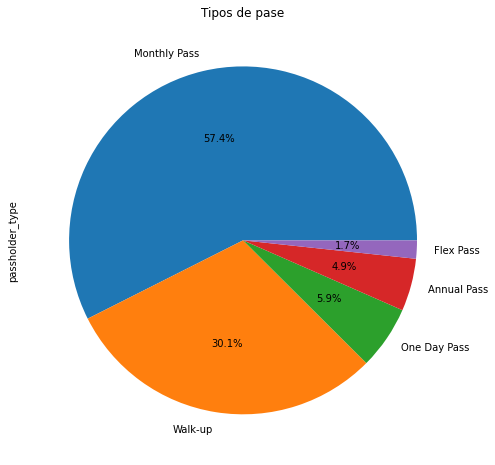

In [36]:
pass_types = passtype_analysis['passholder_type'].value_counts()

pass_types.plot(kind='pie', autopct='%1.1f%%', figsize=(8,8))
plt.title('Tipos de pase')

plt.savefig('images/passtypes.png')

Podemos ver que el pase mas popular es el pase Mensual con 57.4% de los viajes,
mientras que el pase anual solo ocupa el 4.9% de los viajes totales realizados.

Vamos a ver como a sido el uso de los pases a traves del tiempo

Para eso necesitaremos agregar la columna de fecha nuevamente

Establecemos la columna *date* como indice

In [37]:
passtype_analysis.set_index('date', inplace=True)

passtype_analysis.index = pd.to_datetime(passtype_analysis.index)
passtype_analysis.sort_index(inplace=True)

Agruparemos cuantos viajes se realizan por tipo de pase al dia

In [38]:
# Agrupamos por fecha y tipo de pase, contamos el número de viajes realizados
grourped_passtype_date = passtype_analysis.groupby(['date', 'passholder_type'])[['trip_id']].count()
grourped_passtype_date.reset_index(inplace=True)

Ahora analizaremos el numero medio de viajes al año y como se usaron los diferentes tipos de pase

In [39]:
# Calculamos la media de viajes realizados por tipo de pase al año
grouped_passtype_by_year = grourped_passtype_date.groupby(['passholder_type', pd.Grouper(key='date', freq='1y')]
                                                          ).agg({'trip_id':'median'})
grouped_passtype_by_year.reset_index(inplace=True)

In [40]:
# Añadiremos la columna *year*
grouped_passtype_by_year['year'] = grouped_passtype_by_year['date'].apply(lambda x: x.year)

Dividimos por tipo de pase y graficaremos la frecuencia media de uso diario por cada año

In [41]:
annual = grouped_passtype_by_year[grouped_passtype_by_year['passholder_type'] == 'Annual Pass']
flex = grouped_passtype_by_year[grouped_passtype_by_year['passholder_type'] == 'Flex Pass']
monthly = grouped_passtype_by_year[grouped_passtype_by_year['passholder_type'] == 'Monthly Pass']
one_day = grouped_passtype_by_year[grouped_passtype_by_year['passholder_type'] == 'One Day Pass']
walk_up = grouped_passtype_by_year[grouped_passtype_by_year['passholder_type'] == 'Walk-up']

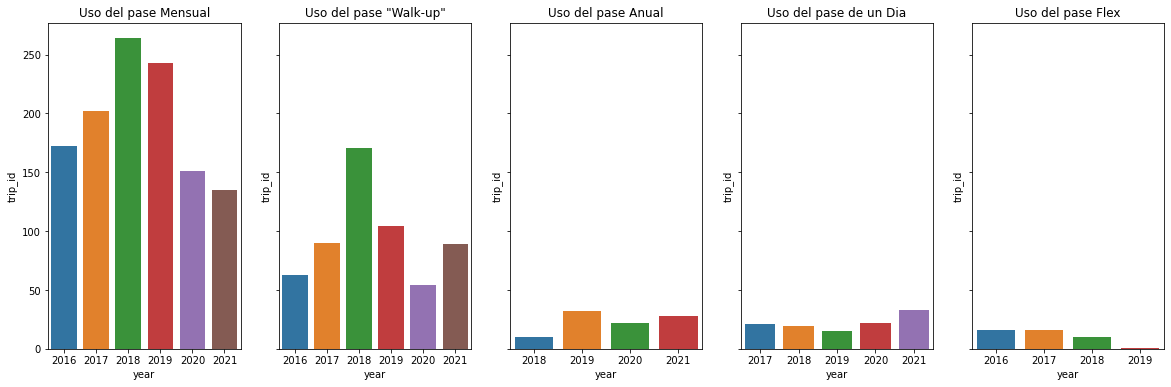

In [42]:
fig, axs = plt.subplots(1,5, figsize=(20, 6), sharey=True)

sns.barplot(x='year', y='trip_id', data=monthly, ax=axs[0])
axs[0].set_title('Uso del pase Mensual')

sns.barplot(x='year', y='trip_id', data=walk_up, ax=axs[1])
axs[1].set_title('Uso del pase "Walk-up"')

sns.barplot(x='year', y='trip_id', data=annual, ax=axs[2])
axs[2].set_title('Uso del pase Anual')

sns.barplot(x='year', y='trip_id', data=one_day, ax=axs[3])
axs[3].set_title('Uso del pase de un Dia')

sns.barplot(x='year', y='trip_id', data=flex, ax=axs[4])
axs[4].set_title('Uso del pase Flex')

plt.savefig('images/use_passtype_years.png')

Podemos ver que el uso del pase anual ha sido constante desde 2019.

Sin embargo el plan con mayor uso es el del plan mesual, seguido del plan "Walk-up"

## Conclusiones

Para comenzar vimos un buen crecimiento en los primeros dos años del servicio de bicicletas aunque claramente podemos notar un descenso su uso debido a la situación de pandemia global. A pesar de eso el servicio sigue siendo utilizado y daremos alguna recomendaciones para estar preparados para cuando se reestablescan las labores cotidianas.

Podemos dividir la demanda de bicicletas semanal en "Entre semana" y "Fines de semana".
- Entre semana 

In [43]:
weekday = trayectory_analysis[trayectory_analysis['day'] < 5]
weekend = trayectory_analysis[trayectory_analysis['day'] > 4]

Las estaciones con más afluencia son:

In [44]:
group_weekday = weekday.groupby(['date', 'start_station', 'end_station'])[['trip_id']].count()
group_weekday.reset_index(inplace=True)

In [45]:
start_end_trips_b_station = group_weekday.groupby(['start_station', 'end_station'])[['trip_id']].mean()

In [46]:
start_end_trips_b_station.sort_values(by='trip_id', ascending=False, inplace=True)

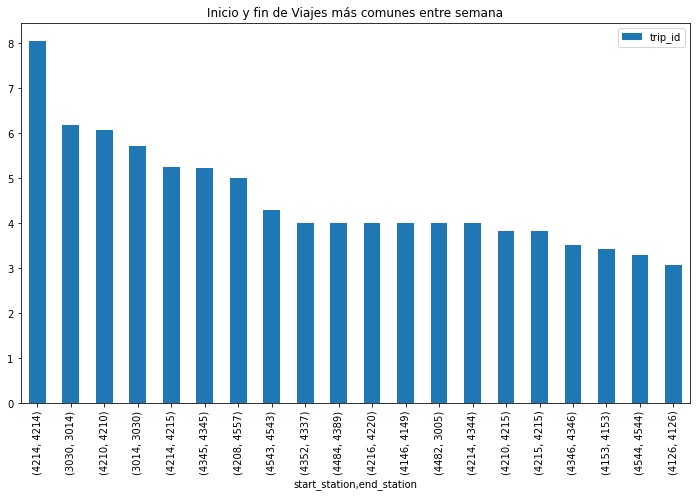

In [47]:
start_end_trips_b_station[:20].plot(kind='bar', figsize=(12, 7), title="Inicio y fin de Viajes más comunes entre semana")
plt.savefig('images/startrip_weekday.png')

La estación donde más se inicia y termina un viaje es entre las estaciones (**4214** y **4210**) seguidas de las estaciones (**3030** y **3014**) y la estación **4210** estos son viajes redondos donde hay intercambio equivalente de bicicletas.

Por lo que hay que optimizar el número de bicicletas en las siguientes estaciones, que suelen tener solo viajes de ida, donde hay más inicios pero pocos fines de viaje, ya que la disponibilidad de bicicletas puede llegar a ser nulo.

Ahora veamos el fin de semana que estaciones tienen mas demanda

In [48]:
group_weekend = weekend.groupby(['date', 'start_station', 'end_station'])[['trip_id']].count()
group_weekend.reset_index(inplace=True)

In [49]:
start_end_trips_b_station = group_weekend.groupby(['start_station', 'end_station'])[['trip_id']].mean()

start_end_trips_b_station.sort_values(by='trip_id', ascending=False, inplace=True)

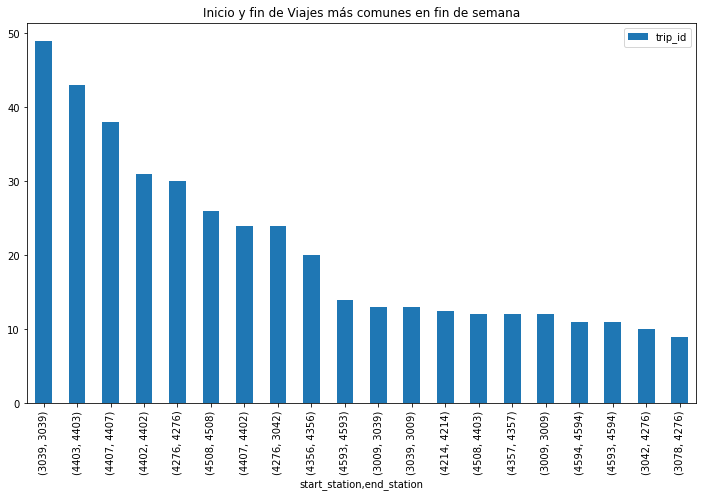

In [50]:
start_end_trips_b_station[:20].plot(kind='bar', figsize=(12, 7), title="Inicio y fin de Viajes más comunes en fin de semana")
plt.savefig('images/startrip_weekend.png')

Podemos notar que el fin de semana los viajes más comunes son del tipo redondo y en mayor cantidad que entre semana, siendo las estaciones con más actividad: **3039**, **4403**, **4402**, **4476** y **44508** con más de 20 viajes en promedio.

Por el momento el pase anual no muestra señales de aumento en su uso, sin embargo, el pase mensual que representa a la mayoría de los usuarios ha presentado bajas considerables, recomendamos enfocarse a retener este tipo de usuario.